# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense,
    GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout, concatenate, Activation
)

from tensorflow.keras import Model

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, precision_score, recall_score,
    roc_auc_score
)

from sklearn.model_selection import train_test_split

from imblearn.metrics import specificity_score

from matplotlib import pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Input data

In [2]:
targetnames = ['benign', 'malignant']
num_classes = 2
batch_size = 16
image_size = 224

In [3]:
train_path = '/kaggle/input/breakhis-aug/BreakHis/train'
test_path = '/kaggle/input/breakhis-aug/BreakHis/test'
val_path = '/kaggle/input/breakhis-aug/BreakHis/val'

# Layer 1 (DN)

## DN121

### Data Generation

In [4]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [5]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 15984 images belonging to 2 classes.

Test Batches: 
Found 1187 images belonging to 2 classes.

Val Batches: 
Found 1186 images belonging to 2 classes.


### Import model

In [6]:
from tensorflow.keras.applications.densenet import DenseNet121
# Create a new instance of DenseNet121
DN121 = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

29084464/29084464 [==============================] - 2s 0us/step


In [7]:
## Fine tuning
MainInput=Input(shape=(image_size, image_size, 3))
dn121 = DN121(MainInput)

# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((16, 16, 4))(dn121)

# DN121_ccnn

Accuracy 98.99%

In [8]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn121 = Model(inputs=MainInput, outputs=conv)

2


In [9]:
from tensorflow.keras import models
model_dn121.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN121.hdf5")

In [10]:
prediction_dn121_cc = model_dn121.predict(test_batches)

75/75 [==============================] - 36s 427ms/step


In [11]:
#geting predictions on test dataset
y_pred = np.argmax(prediction_dn121_cc, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = prediction_dn121_cc

In [12]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.98      0.99      0.98       372
   malignant       1.00      0.99      0.99       815

    accuracy                           0.99      1187
   macro avg       0.99      0.99      0.99      1187
weighted avg       0.99      0.99      0.99      1187



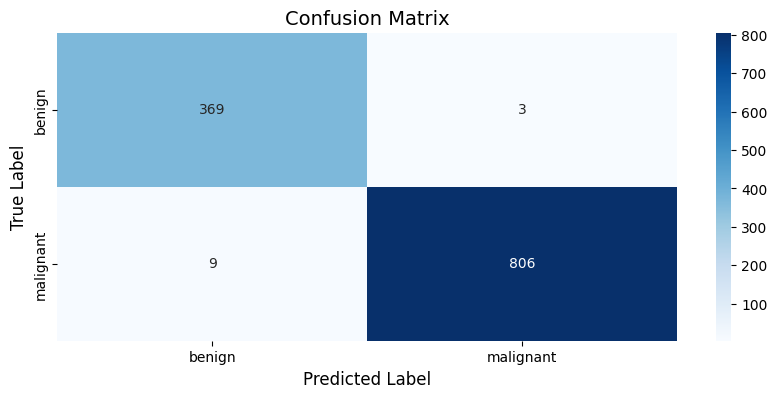

In [13]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [14]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9898904802021904


In [15]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-prediction_dn121_cc, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-prediction_dn121_cc, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9898904802021904
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [16]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9899920871540695
Weighted Recall (sensitivity): 0.9898904802021904
Weighted F1-Score: 0.9899122430600802
Weighted Specificity: 0.9910020588835012


### DN121_cacnn

Accuracy: 0.9840

In [17]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [18]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn121_ca = Model(inputs=MainInput, outputs=conv)

2


In [19]:
from tensorflow.keras import models
model_dn121_ca.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN121_CA.hdf5")

In [20]:
predictions_dn121_ca = model_dn121_ca.predict(test_batches)

75/75 [==============================] - 19s 214ms/step


In [21]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn121_ca, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn121_ca

In [22]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.99      0.93      0.96       372
   malignant       0.97      1.00      0.98       815

    accuracy                           0.97      1187
   macro avg       0.98      0.96      0.97      1187
weighted avg       0.97      0.97      0.97      1187



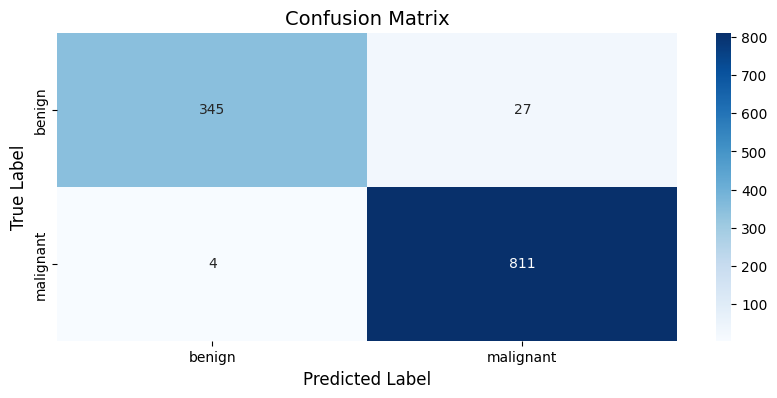

In [23]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [24]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9738837405223252


In [25]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn121_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn121_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9738837405223252
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [26]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9742859644516813
Weighted Recall (sensitivity): 0.9738837405223252
Weighted F1-Score: 0.9736488764378745
Weighted Specificity: 0.9486276388562618


### DN121_seacnn

Accuracy: 0.9666666666666667

In [27]:
### Squeeze and Excitation Attention
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [28]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 16
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn121_sea = Model(inputs=MainInput, outputs=conv)

2


In [29]:
from tensorflow.keras import models
model_dn121_sea.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN121_SEA.hdf5")

In [30]:
predictions_dn121_sea = model_dn121_sea.predict(test_batches)

75/75 [==============================] - 18s 208ms/step


In [31]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn121_sea, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn121_sea

In [32]:
classnames = ['benign', 'malignant']


from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.98      0.99      0.99       372
   malignant       1.00      0.99      0.99       815

    accuracy                           0.99      1187
   macro avg       0.99      0.99      0.99      1187
weighted avg       0.99      0.99      0.99      1187



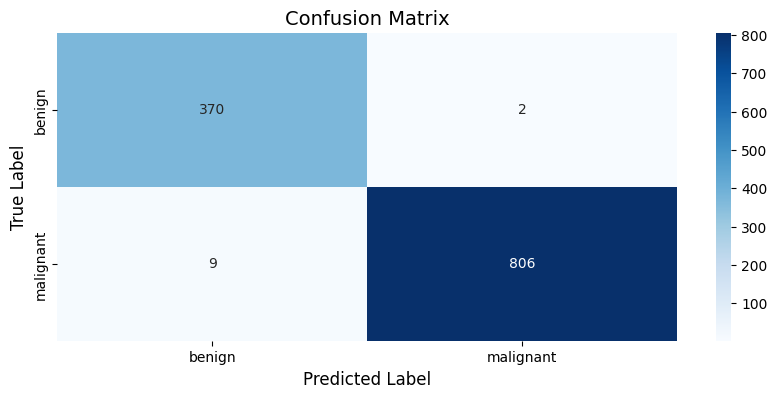

In [33]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [34]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9907329401853412


In [35]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn121_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn121_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9907329401853412
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [36]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9908583826286905
Weighted Recall (sensitivity): 0.9907329401853412
Weighted F1-Score: 0.9907561444622053
Weighted Specificity: 0.9928477709433612


### DN121_sacnn

Accuracy: 0.9666666666666667

In [37]:
### Soft Attention
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


In [38]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn121_sa = Model(inputs=MainInput, outputs=conv)

2


In [39]:
from tensorflow.keras import models
model_dn121_sa.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN121_SA.hdf5")

In [40]:
predictions_dn121_sa = model_dn121_sa.predict(test_batches)

75/75 [==============================] - 18s 208ms/step


In [41]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn121_sa, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn121_sa

In [42]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.98      0.98      0.98       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.99      1187
   macro avg       0.98      0.98      0.98      1187
weighted avg       0.99      0.99      0.99      1187



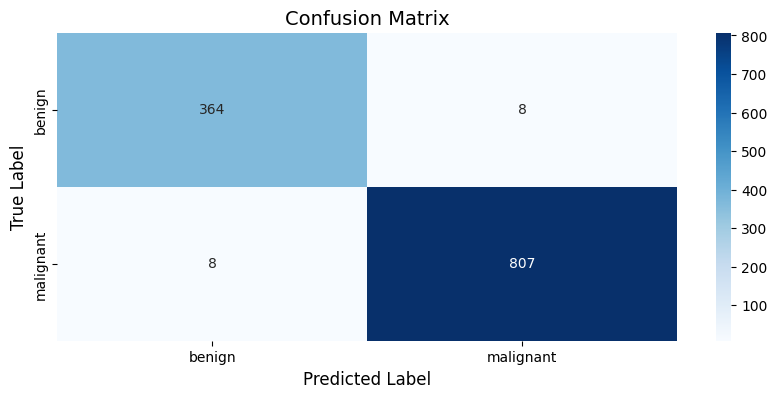

In [43]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [44]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9865206402695872


In [45]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn121_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn121_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9865206402695872
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [46]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9865206402695872
Weighted Recall (sensitivity): 0.9865206402695872
Weighted F1-Score: 0.9865206402695872
Weighted Specificity: 0.9821580324660814


### MV

Accuracy: 0.9733333333333334

In [47]:
# Take the majority vote of the predictions for each image
MV_predictions_dn121 = predictions_dn121_ca + predictions_dn121_sa + predictions_dn121_sea + prediction_dn121_cc

# Take the argmax of the outputs to get the predicted classes
MV_predictions_dn121_f = np.argmax(MV_predictions_dn121, axis=1)

In [48]:
y_pred = MV_predictions_dn121_f
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.995787700084246


In [49]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9957862558003444
Weighted Recall (sensitivity): 0.995787700084246
Weighted F1-Score: 0.9957861567518209
Weighted Specificity: 0.9936937960566604


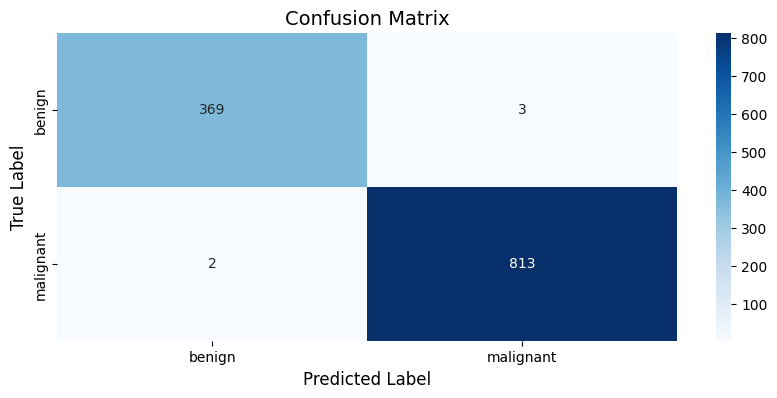

In [50]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [51]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.58%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.75%


# SAvg

In [52]:
# Calculate the average of the softmax outputs for each image
SAvg_predictions_dn121 = (predictions_dn121_ca + predictions_dn121_sa + predictions_dn121_sea + prediction_dn121_cc) / 4

# Take the argmax of the averaged softmax outputs to get the predicted classes
SMavg_predictions = np.argmax(SAvg_predictions_dn121, axis=1)

In [53]:
y_pred = SMavg_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.995787700084246


In [54]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9957862558003444
Weighted Recall (sensitivity): 0.995787700084246
Weighted F1-Score: 0.9957861567518209
Weighted Specificity: 0.9936937960566604


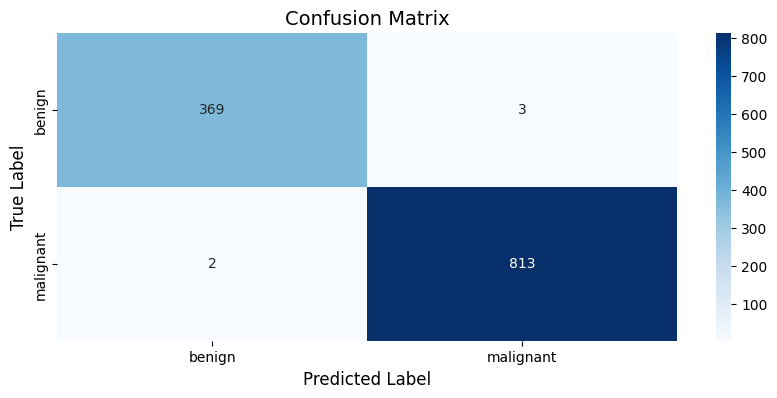

In [55]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [56]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.58%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.75%


### WAvg

In [57]:
# weighted average

# Define the weights for each model's prediction
weights = [0.35, 0.10, 0.40, 0.15]


In [58]:
# Calculate the weighted average of the softmax outputs for each image
WAvg_predictions_dn121 = (weights[0] * prediction_dn121_cc) + (weights[1] *  predictions_dn121_ca) + (weights[2] * predictions_dn121_sea) +(weights[3] * predictions_dn121_sa)/ 4

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(WAvg_predictions_dn121, axis=1)

In [59]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.995787700084246


In [60]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9957924059755564
Weighted Recall (sensitivity): 0.995787700084246
Weighted F1-Score: 0.9957892342214346
Weighted Specificity: 0.9951549742346405


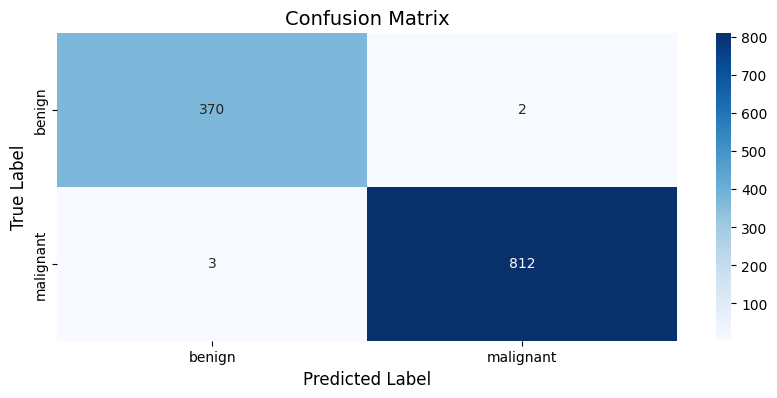

In [61]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [62]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.58%
Accuracy for each class:
Class 0: 99.46%
Class 1: 99.63%


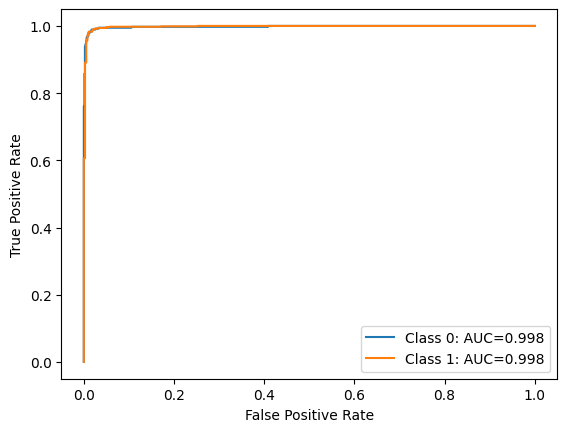

DN121_1st


In [63]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("DN121_1st")

## DN169

### Data Generation

In [64]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [65]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 15984 images belonging to 2 classes.

Test Batches: 
Found 1187 images belonging to 2 classes.

Val Batches: 
Found 1186 images belonging to 2 classes.


### Import model

In [66]:
from tensorflow.keras.applications.densenet import DenseNet169

DN169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

51877672/51877672 [==============================] - 2s 0us/step


In [67]:
# Fine tuning
MainInput=Input(shape=(image_size, image_size, 3))
dn169 = DN169(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((8, 8, 26))(dn169)

# DN169_ccnn

In [68]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn169 = Model(inputs=MainInput, outputs=conv)

2


In [69]:
from tensorflow.keras import models
model_dn169.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN169.hdf5")

In [70]:
predictions_dn169_cc = model_dn169.predict(test_batches)

75/75 [==============================] - 20s 220ms/step


In [71]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn169_cc, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_dn169_cc

In [72]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.99      0.96      0.98       372
   malignant       0.98      1.00      0.99       815

    accuracy                           0.98      1187
   macro avg       0.99      0.98      0.98      1187
weighted avg       0.98      0.98      0.98      1187



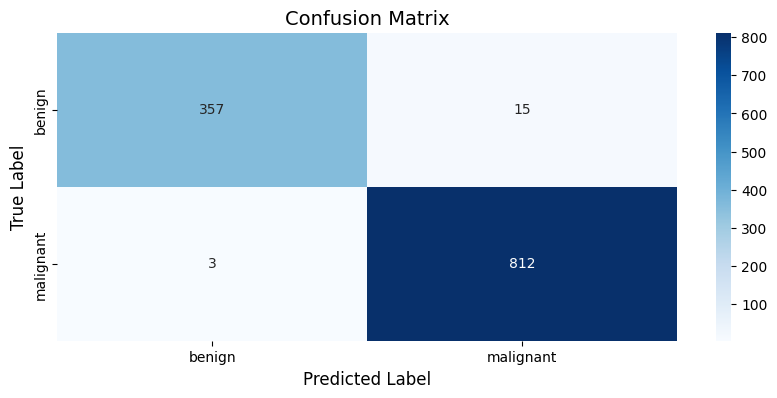

In [73]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [74]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.9848357203032856


In [75]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn169_cc, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn169_cc, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9848357203032856
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [76]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9849348392347979
Weighted Recall (sensitivity): 0.9848357203032856
Weighted F1-Score: 0.9847668344257872
Weighted Specificity: 0.971160717456461


### DN169_cacnn

Accuracy: 0.9644444444444444

In [77]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [78]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn169_ca = Model(inputs=MainInput, outputs=conv)

2


In [79]:
from tensorflow.keras import models
model_dn169_ca.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN169_CA.hdf5")

In [80]:
predictions_dn169_ca = model_dn169_ca.predict(test_batches)

75/75 [==============================] - 19s 214ms/step


In [81]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn169_ca, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn169_ca

In [82]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.98      0.99      0.99       372
   malignant       1.00      0.99      0.99       815

    accuracy                           0.99      1187
   macro avg       0.99      0.99      0.99      1187
weighted avg       0.99      0.99      0.99      1187



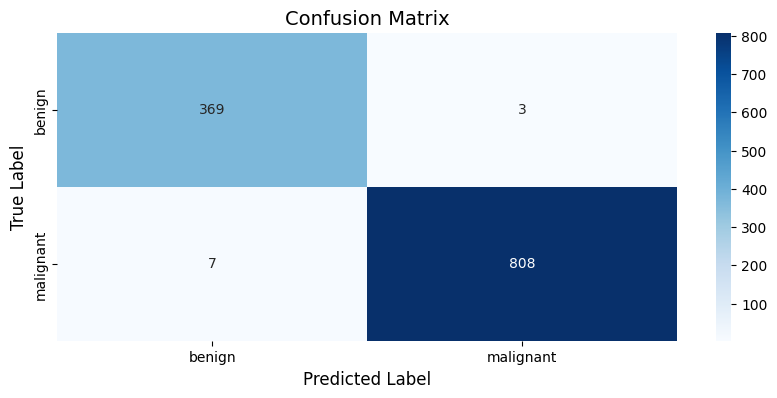

In [83]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [84]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.991575400168492


In [85]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn169_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn169_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.991575400168492
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [86]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9916256710510818
Weighted Recall (sensitivity): 0.991575400168492
Weighted F1-Score: 0.9915875634750744
Weighted Specificity: 0.9917711266472611


### DN169_seacnn

Accuracy: 0.9688888888888889

In [87]:
### Squeeze and Excitation Attention
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [88]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 4
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn169_sea = Model(inputs=MainInput, outputs=conv)

2


In [89]:
from tensorflow.keras import models
model_dn169_sea.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN169_SEA.hdf5")

In [90]:
predictions_dn169_sea = model_dn169_sea.predict(test_batches)

75/75 [==============================] - 19s 214ms/step


In [91]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn169_sea, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn169_sea

In [92]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.98      0.97       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.98      1187
   macro avg       0.98      0.98      0.98      1187
weighted avg       0.98      0.98      0.98      1187



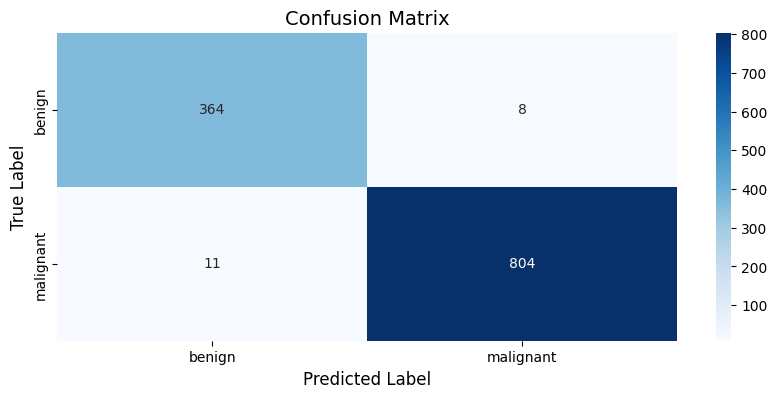

In [93]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [94]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9839932603201348


In [95]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn169_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn169_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9839932603201348
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [96]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9840424965035837
Weighted Recall (sensitivity): 0.9839932603201348
Weighted F1-Score: 0.98401064507849
Weighted Specificity: 0.9810044308204419


### DN169_sacnn

Accuracy: 0.9711111111111111

In [97]:
### Soft Attention
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


In [98]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn169_sa = Model(inputs=MainInput, outputs=conv)

2


In [99]:
from tensorflow.keras import models
model_dn169_sa.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN169_SA.hdf5")

In [100]:
predictions_dn169_sa = model_dn169_sa.predict(test_batches)

75/75 [==============================] - 19s 208ms/step


In [101]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn169_sa, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn169_sa

In [102]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.99      0.98      0.98       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.99      1187
   macro avg       0.99      0.99      0.99      1187
weighted avg       0.99      0.99      0.99      1187



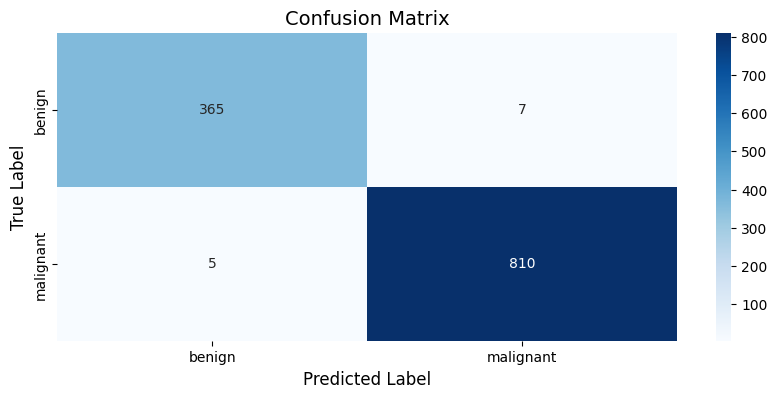

In [103]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [104]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9898904802021904


In [105]:
import numpy as np
from sklearn.metrics import accuracy_score


# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn169_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn169_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9898904802021904
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [106]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9898821472922377
Weighted Recall (sensitivity): 0.9898904802021904
Weighted F1-Score: 0.9898830500711355
Weighted Specificity: 0.985157346171581


# MV

In [107]:
# Take the majority vote of the predictions for each image
MV_predictions_dn169 = predictions_dn169_ca + predictions_dn169_sa + predictions_dn169_sea + predictions_dn169_cc

# Take the argmax of the outputs to get the predicted classes
MV_predictions_dn169_f = np.argmax(MV_predictions_dn169, axis=1)

In [108]:
y_pred = MV_predictions_dn169_f
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.991575400168492


In [109]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9915767306980084
Weighted Recall (sensitivity): 0.991575400168492
Weighted F1-Score: 0.9915629426074589
Weighted Specificity: 0.9859264139353406


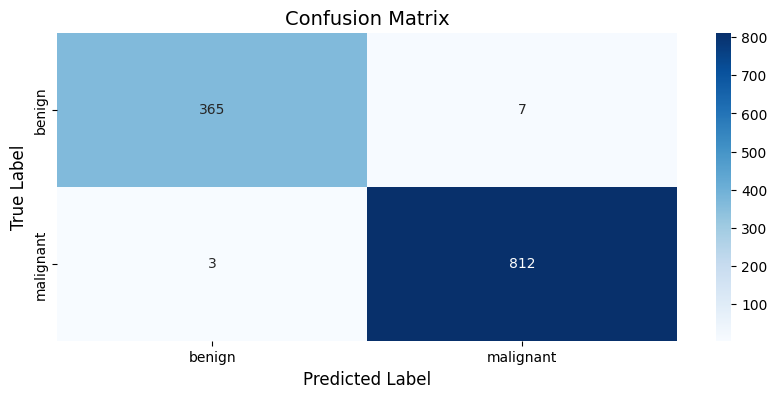

In [110]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [111]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.16%
Accuracy for each class:
Class 0: 98.12%
Class 1: 99.63%


### SAvg

Accuracy: 0.9755555555555555

In [112]:
# Calculate the average of the softmax outputs for each image
SAvg_predictions_dn169 = (predictions_dn169_ca + predictions_dn169_sa + predictions_dn169_sea + predictions_dn169_cc) / 4

# Take the argmax of the averaged softmax outputs to get the predicted classes
SMavg_predictions = np.argmax(SAvg_predictions_dn169, axis=1)

In [113]:
y_pred = SMavg_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.991575400168492


In [114]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9915767306980084
Weighted Recall (sensitivity): 0.991575400168492
Weighted F1-Score: 0.9915629426074589
Weighted Specificity: 0.9859264139353406


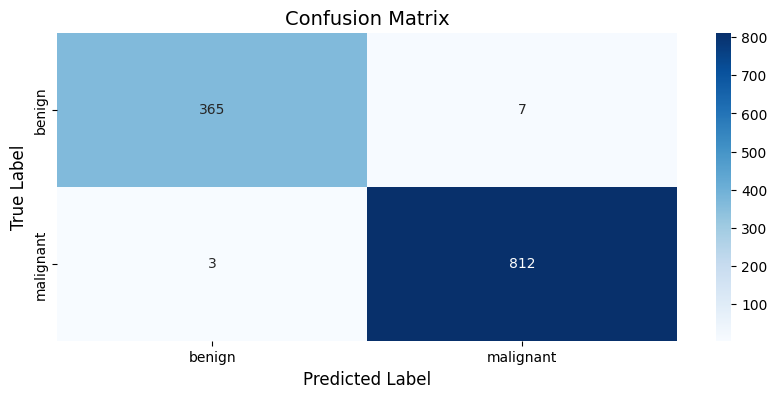

In [115]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [116]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.16%
Accuracy for each class:
Class 0: 98.12%
Class 1: 99.63%


# WAvg

In [117]:
# weighted average

# Define the weights for each model's prediction
weights = [0.10, 0.40, 0.15, 0.35]


In [118]:
# Calculate the weighted average of the softmax outputs for each image
WAvg_predictions_dn169 = (weights[0] * predictions_dn169_cc) + (weights[1] *  predictions_dn169_ca) + (weights[2] * predictions_dn169_sea) + (weights[3] * predictions_dn169_sa) / 4

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(WAvg_predictions_dn169, axis=1)

In [119]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9932603201347936


In [120]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9932766283859424
Weighted Recall (sensitivity): 0.9932603201347936
Weighted F1-Score: 0.9932652147057084
Weighted Specificity: 0.9925401944110207


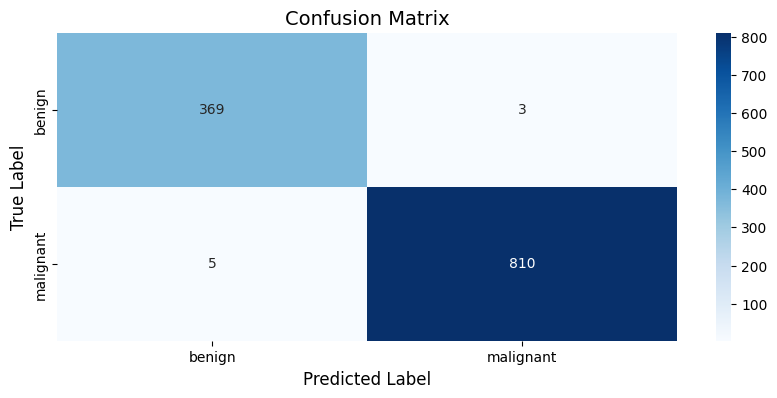

In [121]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [122]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.33%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.39%


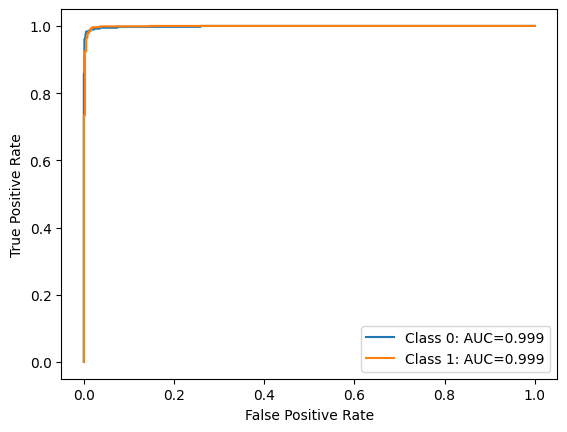

DN169_1st


In [123]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("DN169_1st")

## DN201

### Data Generation

In [124]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [125]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 15984 images belonging to 2 classes.

Test Batches: 
Found 1187 images belonging to 2 classes.

Val Batches: 
Found 1186 images belonging to 2 classes.


### Import model

In [126]:
from tensorflow.keras.applications.densenet import DenseNet201
# Create a new instance of DenseNet201
DN201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

74836368/74836368 [==============================] - 3s 0us/step


In [127]:
## Fine tuning
MainInput=Input(shape=(image_size, image_size, 3))
densenet = DN201(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((8, 8, 30))(densenet)

DN201_CCNN

In [128]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn201 = Model(inputs=MainInput, outputs=conv)


2


In [129]:
from tensorflow.keras import models
model_dn201.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN201.hdf5")

In [130]:
predictions_dn201_cc = model_dn201.predict(test_batches)

75/75 [==============================] - 19s 214ms/step


In [131]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn201_cc, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_dn201_cc

In [132]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.98      0.99      0.98       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.99      1187
   macro avg       0.98      0.99      0.99      1187
weighted avg       0.99      0.99      0.99      1187



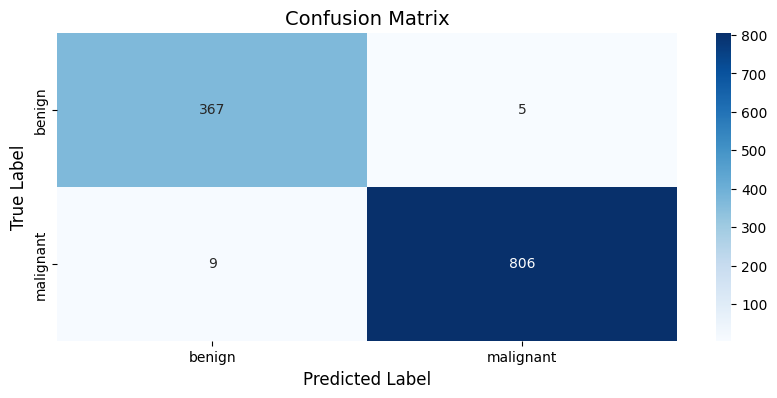

In [133]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [134]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.9882055602358888


In [135]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn201_cc, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn201_cc, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9882055602358888
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [136]:

### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
#print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9882654454662151
Weighted Recall (sensitivity): 0.9882055602358888
Weighted F1-Score: 0.988222588865104
Weighted Specificity: 0.9873106347637814


### DN201_cacnn

Accuracy: 0.98

In [137]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [138]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn201_ca = Model(inputs=MainInput, outputs=conv)

2


In [139]:
from tensorflow.keras import models
model_dn201_ca.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN201_CA.hdf5")

In [140]:
predictions_dn201_ca = model_dn201_ca.predict(test_batches)

75/75 [==============================] - 20s 212ms/step


In [141]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn201_ca, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn201_ca

In [142]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.99      0.98       372
   malignant       1.00      0.98      0.99       815

    accuracy                           0.98      1187
   macro avg       0.98      0.99      0.98      1187
weighted avg       0.99      0.98      0.98      1187



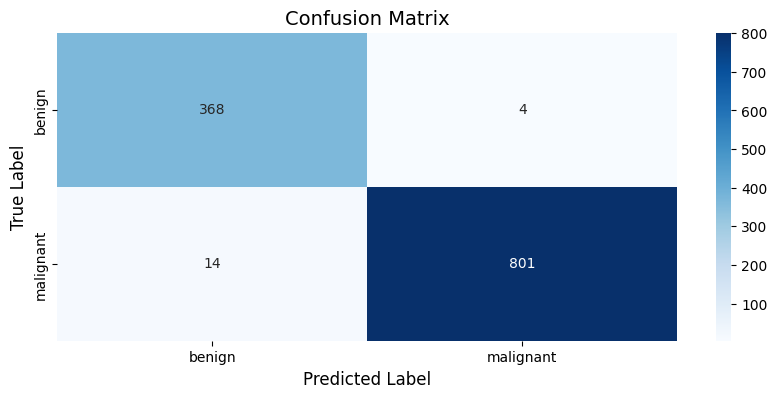

In [143]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [144]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9848357203032856


In [145]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn201_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn201_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9848357203032856
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [146]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9851026139053101
Weighted Recall (sensitivity): 0.9848357203032856
Weighted F1-Score: 0.9848894758548188
Weighted Specificity: 0.9872336774142418


### DN201_seacnn

Accuracy: 0.9622222222222222

In [147]:
### Squeeze and Excitation Attention
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [148]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 4
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn201_sea = Model(inputs=MainInput, outputs=conv)

2


In [149]:
from tensorflow.keras import models
model_dn201_sea.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN201_SEA.hdf5")

In [150]:
predictions_dn201_sea = model_dn201_sea.predict(test_batches)

75/75 [==============================] - 19s 213ms/step


In [151]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn201_sea, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn201_sea

In [152]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.98      0.96      0.97       372
   malignant       0.98      0.99      0.99       815

    accuracy                           0.98      1187
   macro avg       0.98      0.98      0.98      1187
weighted avg       0.98      0.98      0.98      1187



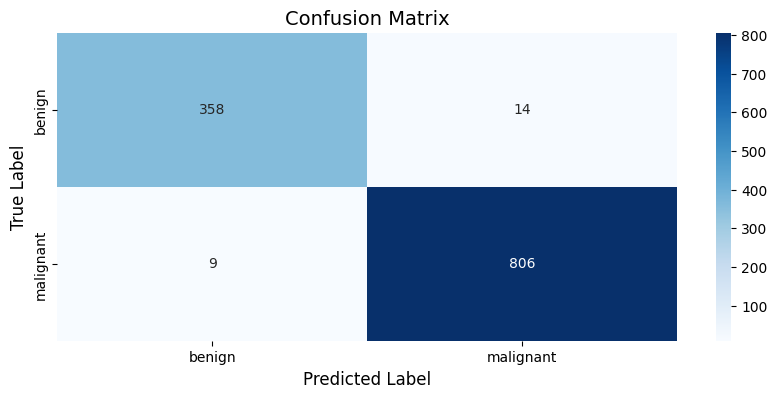

In [153]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [154]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9806234203875316


In [155]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn201_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn201_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9806234203875316
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [156]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9805920387951507
Weighted Recall (sensitivity): 0.9806234203875316
Weighted F1-Score: 0.9805874981864151
Weighted Specificity: 0.9706992262250418


### DN201_sacnn

Accuracy: 0.9666666666666667

In [157]:
### Soft Attention
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()


In [158]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_dn201_sa = Model(inputs=MainInput, outputs=conv)

2


In [159]:
from tensorflow.keras import models
model_dn201_sa.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/DN201_SA.hdf5")

In [160]:
predictions_dn201_sa = model_dn201_sa.predict(test_batches)

75/75 [==============================] - 19s 219ms/step


In [161]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_dn201_sa, axis=1)
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob = predictions_dn201_sa

In [162]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.99      0.98      0.98       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.99      1187
   macro avg       0.99      0.99      0.99      1187
weighted avg       0.99      0.99      0.99      1187



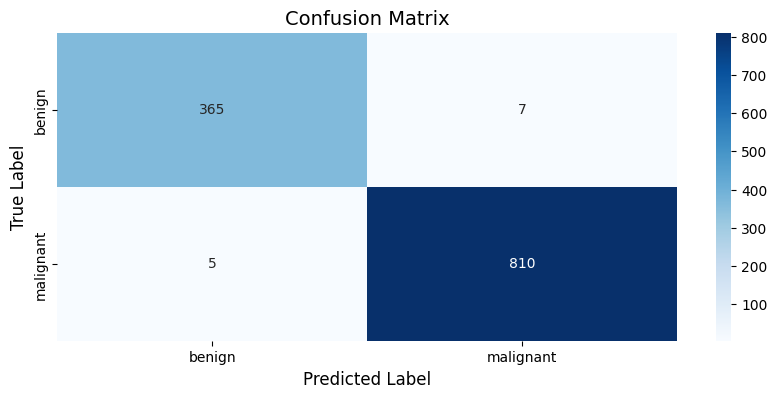

In [163]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [164]:
### Accuracy
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9898904802021904


In [165]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_dn201_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_dn201_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score


Top-1 Accuracy: 0.9898904802021904
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [166]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9898821472922377
Weighted Recall (sensitivity): 0.9898904802021904
Weighted F1-Score: 0.9898830500711355
Weighted Specificity: 0.985157346171581


## MV


In [167]:
# Take the majority vote of the predictions for each image
MV_predictions_dn201 = predictions_dn201_cc + predictions_dn201_ca + predictions_dn201_sa + predictions_dn201_sea

# Take the argmax of the outputs to get the predicted classes
MV_predictions_dn201_f = np.argmax(MV_predictions_dn201, axis=1)

In [168]:
y_pred = MV_predictions_dn201_f
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9932603201347936


In [169]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9932766283859424
Weighted Recall (sensitivity): 0.9932603201347936
Weighted F1-Score: 0.9932652147057084
Weighted Specificity: 0.9925401944110207


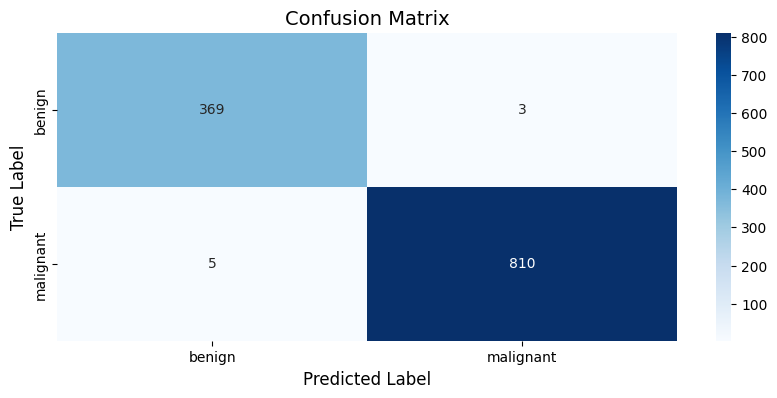

In [170]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [171]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.33%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.39%


# SAvg

In [172]:
# Calculate the average of the softmax outputs for each image
SAvg_predictions_dn201 = (predictions_dn201_cc + predictions_dn201_ca + predictions_dn201_sa + predictions_dn201_sea) / 4

# Take the argmax of the averaged softmax outputs to get the predicted classes
SMavg_predictions = np.argmax(SAvg_predictions_dn201, axis=1)

In [173]:
y_pred = SMavg_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9932603201347936


In [174]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9932766283859424
Weighted Recall (sensitivity): 0.9932603201347936
Weighted F1-Score: 0.9932652147057084
Weighted Specificity: 0.9925401944110207


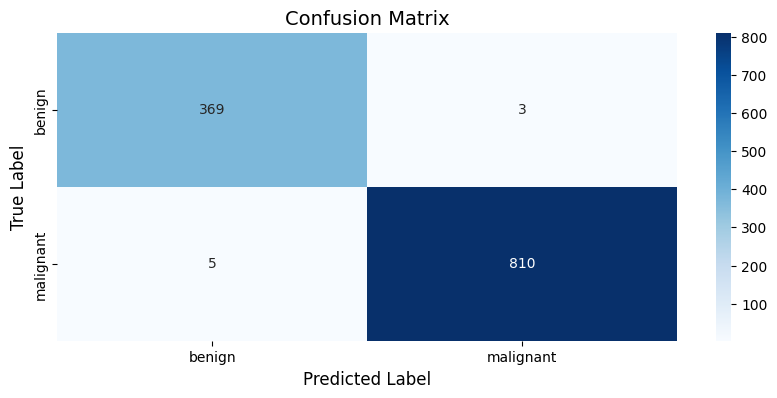

In [175]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [176]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.33%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.39%


### WAvg

Accuracy: 0.9777777777777777

In [177]:
# weighted average

# Define the weights for each model's prediction
weights = [0.25, 0.20, 0.20, 0.35]


In [178]:
# Calculate the weighted average of the softmax outputs for each image
WAvg_predictions_dn201 = (weights[0] * predictions_dn201_sa) + (weights[1] *  predictions_dn201_ca) + (weights[2] * predictions_dn201_sea) + (weights[3] * predictions_dn201_cc) / 4

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(WAvg_predictions_dn201, axis=1)

In [179]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9949452401010952


In [180]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9949452401010952
Weighted Recall (sensitivity): 0.9949452401010952
Weighted F1-Score: 0.9949452401010952
Weighted Specificity: 0.9933092621747804


In [181]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.49%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.39%


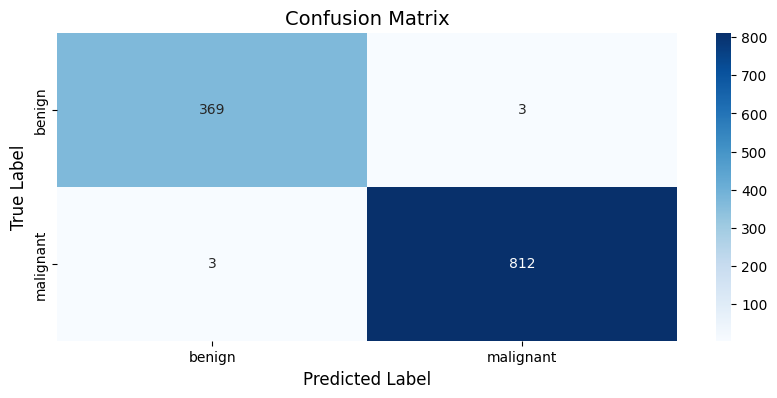

In [182]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [183]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.49%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.63%


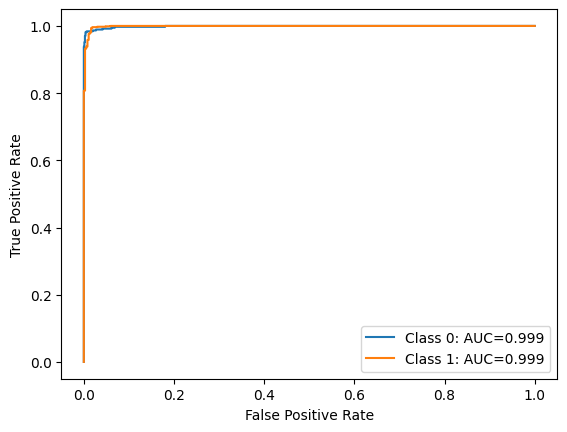

DN201_1st


In [184]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("DN201_1st")

### 2nd layer DN
Accuracy: 0.9777777777777777

In [185]:
# dn121 = most  99.58%
# dn201 = 2nd most  99.49%
# dn169 = 3rd  99.33%

In [186]:
# Define the weights for each model's prediction
weights = [0.40, .30, .30]

In [187]:
# Calculate the weighted average of the softmax outputs for each image
weighted_predictions_dn2 = (weights[0] * MV_predictions_dn121) + (weights[1] * WAvg_predictions_dn201) + (weights[2] * SAvg_predictions_dn169) / 3

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(weighted_predictions_dn2, axis=1)

In [188]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.995787700084246


In [189]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9957862558003444
Weighted Recall (sensitivity): 0.995787700084246
Weighted F1-Score: 0.9957861567518209
Weighted Specificity: 0.9936937960566604


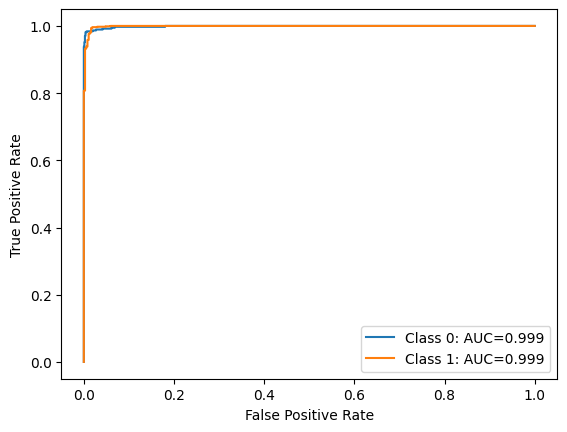

DN_combined


In [190]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("DN_combined")

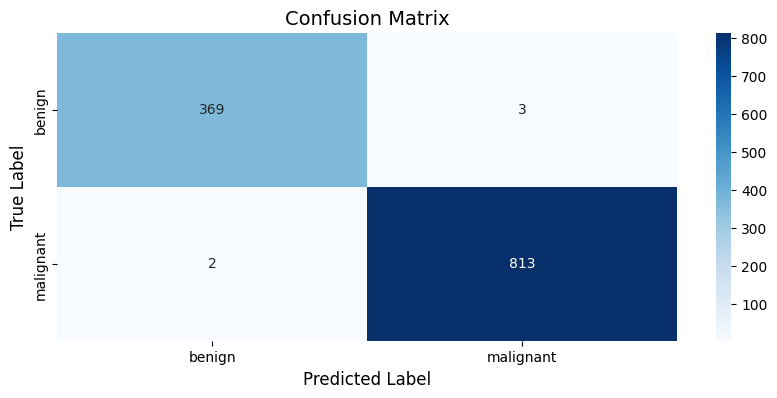

In [191]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [192]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.58%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.75%


# Layer 1 (RN)

## RN50

### Data Generation

In [193]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [194]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 15984 images belonging to 2 classes.

Test Batches: 
Found 1187 images belonging to 2 classes.

Val Batches: 
Found 1186 images belonging to 2 classes.


### Import model

In [195]:
from tensorflow.keras.applications.resnet50 import ResNet50

# Create a new instance of ResNet50
RN50 = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

94765736/94765736 [==============================] - 4s 0us/step


In [196]:
# Fine tuning
MainInput=Input(shape=(image_size, image_size, 3))
resnet = RN50(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((16, 16, 8))(resnet)

# RN50_ccnn

In [197]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn50 = Model(inputs=MainInput, outputs=conv)

2


In [198]:
from tensorflow.keras import models
model_rn50.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN50.hdf5")

In [199]:
predictions_rn50_cc = model_rn50.predict(test_batches)

75/75 [==============================] - 18s 223ms/step


In [200]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn50_cc, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn50_cc

In [201]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.98      0.97       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.98      1187
   macro avg       0.98      0.98      0.98      1187
weighted avg       0.98      0.98      0.98      1187



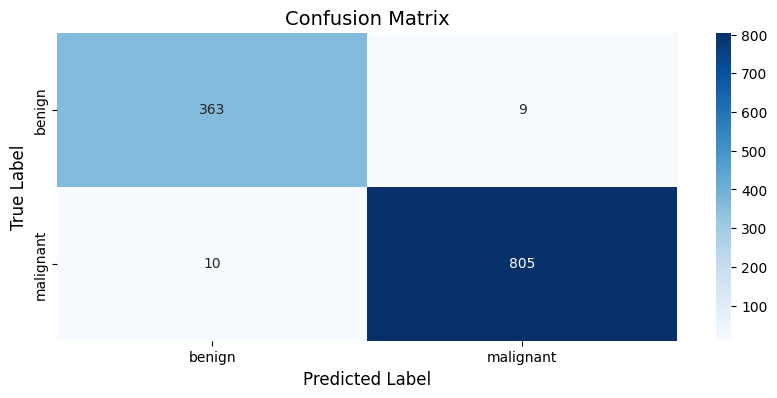

In [202]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [203]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.9839932603201348


In [204]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn50_cc, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn50_cc, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9839932603201348
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [205]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9840065317105459
Weighted Recall (sensitivity): 0.9839932603201348
Weighted F1-Score: 0.9839990900414516
Weighted Specificity: 0.9795432526424617


### RN50_cacnn
AC-97

In [206]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [207]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn50_ca = Model(inputs=MainInput, outputs=conv)

2


In [208]:
from tensorflow.keras import models
model_rn50_ca.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN50_CA.hdf5")

In [209]:
predictions_rn50_ca = model_rn50_ca.predict(test_batches)

75/75 [==============================] - 19s 231ms/step


In [210]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn50_ca, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn50_ca

In [211]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97       372
   malignant       0.99      0.98      0.99       815

    accuracy                           0.98      1187
   macro avg       0.98      0.98      0.98      1187
weighted avg       0.98      0.98      0.98      1187



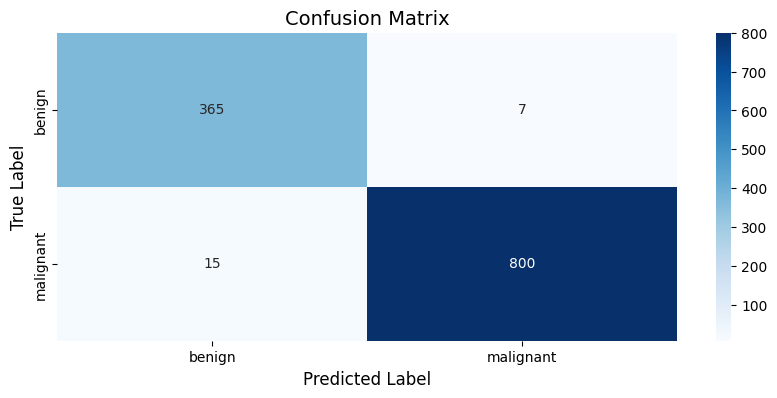

In [212]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [213]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.9814658803706824


In [214]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn50_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn50_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9814658803706824
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [215]:

### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9816734596973858
Weighted Recall (sensitivity): 0.9814658803706824
Weighted F1-Score: 0.9815187592832331
Weighted Specificity: 0.9813120073527822


### RN50_seacnn
AC-96

In [216]:
### Squeeze and Excitation Attention
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [217]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 16
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn50_sea = Model(inputs=MainInput, outputs=conv)

2


In [218]:
from tensorflow.keras import models
model_rn50_sea.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN50_SEA.hdf5")

In [219]:
predictions_rn50_sea = model_rn50_sea.predict(test_batches)

75/75 [==============================] - 18s 227ms/step


In [220]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn50_sea, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn50_sea

In [221]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.98      0.98       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.98      1187
   macro avg       0.98      0.98      0.98      1187
weighted avg       0.98      0.98      0.98      1187



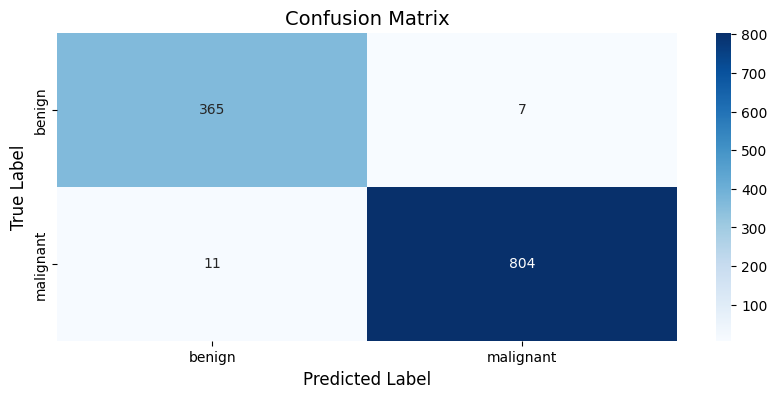

In [222]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [223]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.9848357203032856


In [224]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn50_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn50_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9848357203032856
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [225]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9849052198813484
Weighted Recall (sensitivity): 0.9848357203032856
Weighted F1-Score: 0.9848576142551337
Weighted Specificity: 0.9828501428803016


# RN50_sacnn

AC-98


In [226]:
### Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

In [227]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn50_sa = Model(inputs=MainInput, outputs=conv)

2


In [228]:
from tensorflow.keras import models
model_rn50_sa.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN50_SA.hdf5")


In [229]:
predictions_rn50_sa = model_rn50_sa.predict(test_batches)

75/75 [==============================] - 21s 264ms/step


In [230]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn50_sa, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn50_sa

In [231]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.95      0.98      0.96       372
   malignant       0.99      0.97      0.98       815

    accuracy                           0.98      1187
   macro avg       0.97      0.98      0.97      1187
weighted avg       0.98      0.98      0.98      1187



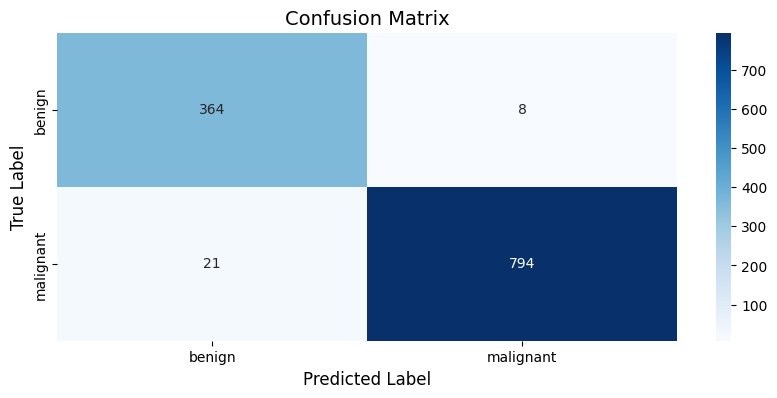

In [232]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [233]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9755686604886268


In [234]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn50_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn50_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9755686604886268
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [235]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9760567945228451
Weighted Recall (sensitivity): 0.9755686604886268
Weighted F1-Score: 0.9756802319669247
Weighted Specificity: 0.977159092001643


### MV

AC-98

In [236]:
# Take the majority vote of the predictions for each image
MV_predictions_rn50 = predictions_rn50_cc + predictions_rn50_ca + predictions_rn50_sa + predictions_rn50_sea

# Take the argmax of the outputs to get the predicted classes
MV_predictions_rn50_f = np.argmax(MV_predictions_rn50, axis=1)

In [237]:
y_pred = MV_predictions_rn50_f
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9898904802021904


In [238]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9899920871540695
Weighted Recall (sensitivity): 0.9898904802021904
Weighted F1-Score: 0.9899122430600802
Weighted Specificity: 0.9910020588835012


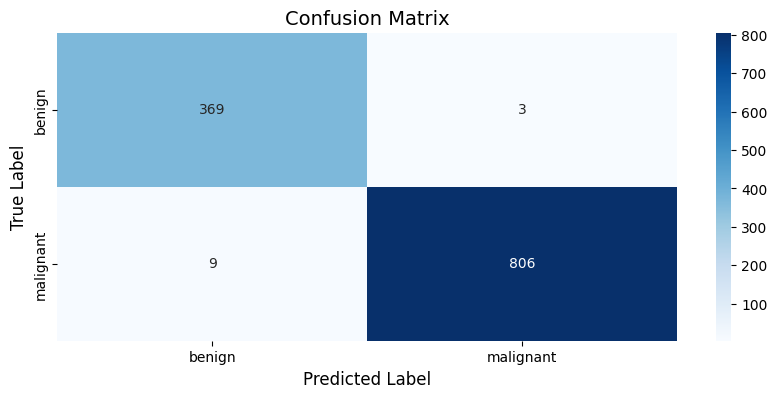

In [239]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [240]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 98.99%
Accuracy for each class:
Class 0: 99.19%
Class 1: 98.90%


# SAvg

In [241]:
# Calculate the average of the softmax outputs for each image
SAvg_predictions_rn50 = (predictions_rn50_cc + predictions_rn50_ca + predictions_rn50_sa + predictions_rn50_sea) / 4

# Take the argmax of the averaged softmax outputs to get the predicted classes
SMavg_predictions = np.argmax(SAvg_predictions_rn50, axis=1)

In [242]:
y_pred = SMavg_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9898904802021904


In [243]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9899920871540695
Weighted Recall (sensitivity): 0.9898904802021904
Weighted F1-Score: 0.9899122430600802
Weighted Specificity: 0.9910020588835012


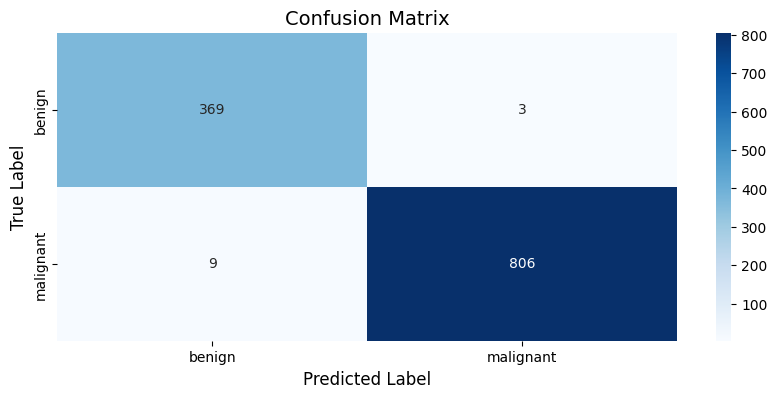

In [244]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [245]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 98.99%
Accuracy for each class:
Class 0: 99.19%
Class 1: 98.90%


# WAvg

In [246]:
# weighted average [0.28, 0.28, 0.10, 0.34]

# Define the weights for each model's prediction
weights = [0.28, 0.28, 0.10, 0.34]

In [247]:
# Calculate the weighted average of the softmax outputs for each image
WAvg_predictions_rn50 = (weights[0] * predictions_rn50_ca) + (weights[1] * predictions_rn50_sea) + (weights[2] * predictions_rn50_sa) + (weights[3] * predictions_rn50_cc) / 4

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(WAvg_predictions_rn50, axis=1)

In [248]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9898904802021904


In [249]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9899920871540695
Weighted Recall (sensitivity): 0.9898904802021904
Weighted F1-Score: 0.9899122430600802
Weighted Specificity: 0.9910020588835012


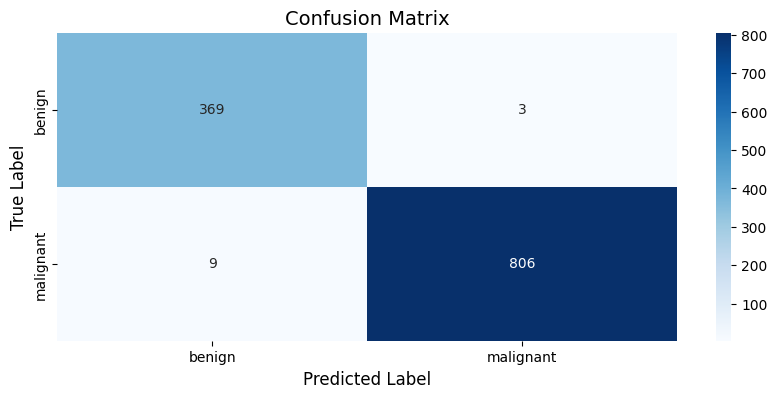

In [250]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [251]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 98.99%
Accuracy for each class:
Class 0: 99.19%
Class 1: 98.90%


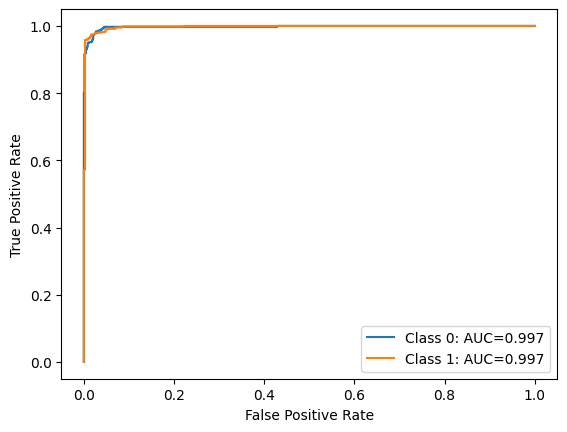

RN_50_1st


In [252]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("RN_50_1st")

## RN101

### Data Generation

In [253]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [254]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 15984 images belonging to 2 classes.

Test Batches: 
Found 1187 images belonging to 2 classes.

Val Batches: 
Found 1186 images belonging to 2 classes.


In [255]:
from tensorflow.keras.applications.resnet import ResNet101

RN101 = ResNet101(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

171446536/171446536 [==============================] - 6s 0us/step


In [256]:
# Fine tuning

MainInput=Input(shape=(image_size, image_size, 3))
resnet = RN101(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((16, 16, 8))(resnet)

# RN101_ccnn

In [257]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn101 = Model(inputs=MainInput, outputs=conv)

2


In [258]:
from tensorflow.keras import models
model_rn101.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN101.hdf5")

In [259]:
predictions_rn101_cc = model_rn101.predict(test_batches)

75/75 [==============================] - 19s 228ms/step


In [260]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn101_cc, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn101_cc

In [261]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.95      0.95      0.95       372
   malignant       0.98      0.98      0.98       815

    accuracy                           0.97      1187
   macro avg       0.96      0.96      0.96      1187
weighted avg       0.97      0.97      0.97      1187



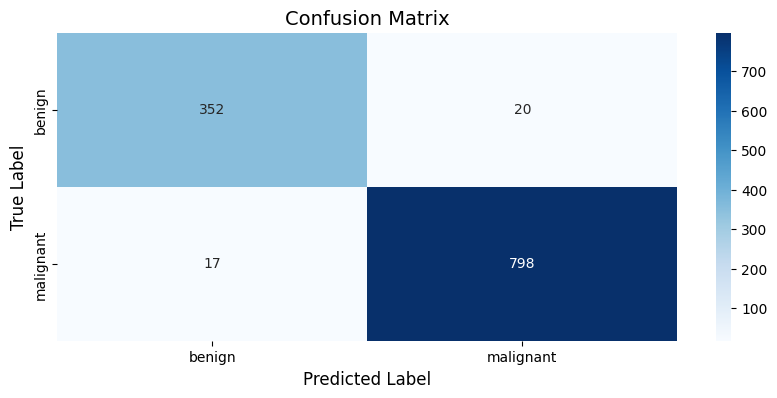

In [262]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [263]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.9688289806234204


In [264]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn101_cc, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn101_cc, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9688289806234204
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [265]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.968774337195567
Weighted Recall (sensitivity): 0.9688289806234204
Weighted F1-Score: 0.9687945136836038
Weighted Specificity: 0.9565486828108432


**RN101_cacnn**

AC-97

In [266]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [267]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn101_ca = Model(inputs=MainInput, outputs=conv)

2


In [268]:
from tensorflow.keras import models
model_rn101_ca.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN101_CA.hdf5")


In [269]:
predictions_rn101_ca = model_rn101_ca.predict(test_batches)

75/75 [==============================] - 23s 266ms/step


In [270]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn101_ca, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn101_ca

In [271]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.98      0.98      0.98       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.99      1187
   macro avg       0.99      0.99      0.99      1187
weighted avg       0.99      0.99      0.99      1187



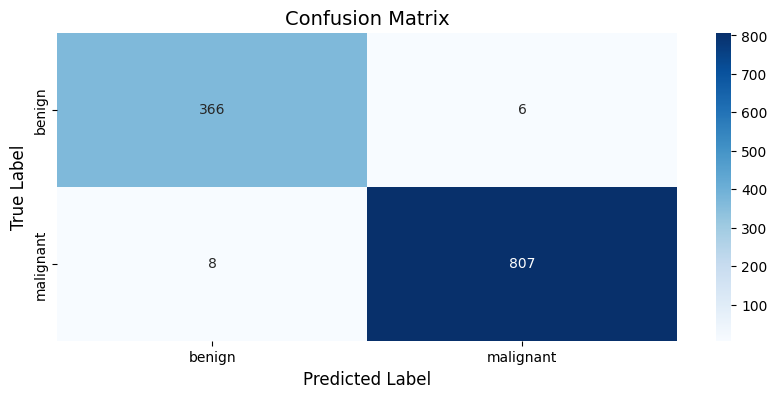

In [272]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [273]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9882055602358888


In [274]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn101_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn101_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9882055602358888
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [275]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.988229166470987
Weighted Recall (sensitivity): 0.9882055602358888
Weighted F1-Score: 0.9882141257349897
Weighted Specificity: 0.9858494565858014


**RN101_seacnn**

AC-96

In [276]:
### Squeeze and Excitation Attention

def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [277]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 16
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn101_sea = Model(inputs=MainInput, outputs=conv)

2


In [278]:
from tensorflow.keras import models
model_rn101_sea.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN101_SEA.hdf5")


In [279]:
predictions_rn101_sea = model_rn101_sea.predict(test_batches)

75/75 [==============================] - 18s 210ms/step


In [280]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn101_sea, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn101_sea


In [281]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.98      0.98      0.98       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.99      1187
   macro avg       0.99      0.99      0.99      1187
weighted avg       0.99      0.99      0.99      1187



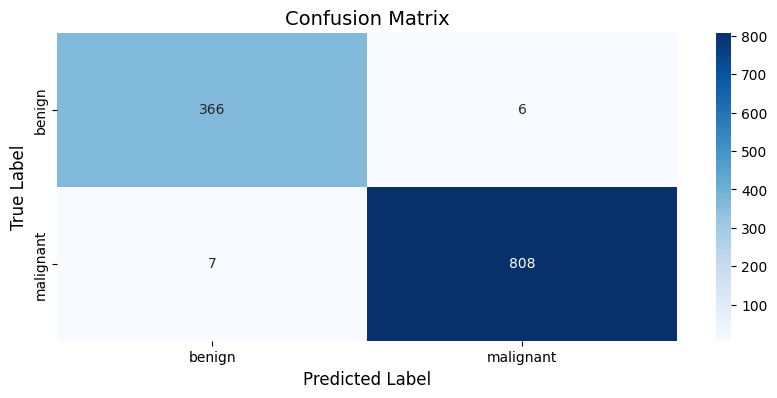

In [282]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [283]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9890480202190396


In [284]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn101_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn101_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9890480202190396
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [285]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9890576206812646
Weighted Recall (sensitivity): 0.9890480202190396
Weighted F1-Score: 0.98905200897573
Weighted Specificity: 0.9862339904676812


### RN101_sacnn

AC-98

In [286]:
### Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

In [287]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn101_sa = Model(inputs=MainInput, outputs=conv)

2


In [288]:
from tensorflow.keras import models
model_rn101_sa.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN101_SA.hdf5")

In [289]:
predictions_rn101_sa = model_rn101_sa.predict(test_batches)

75/75 [==============================] - 18s 212ms/step


In [290]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn101_sa, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn101_sa


In [291]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.97      0.98      0.97       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.98      1187
   macro avg       0.98      0.98      0.98      1187
weighted avg       0.98      0.98      0.98      1187



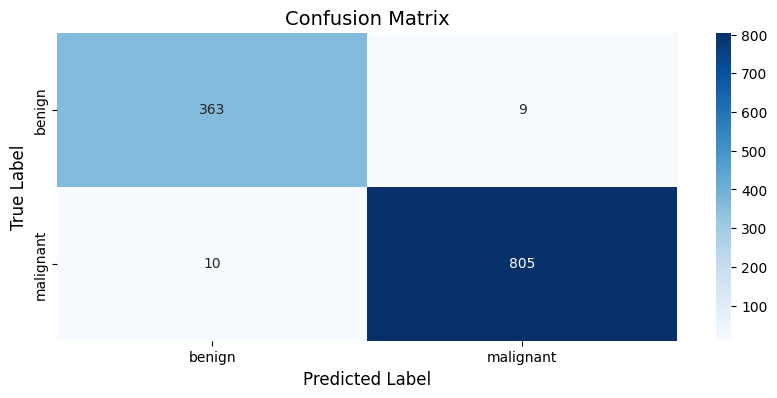

In [292]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [293]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Accuracy: 0.9839932603201348


In [294]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn101_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn101_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9839932603201348
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [295]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9840065317105459
Weighted Recall (sensitivity): 0.9839932603201348
Weighted F1-Score: 0.9839990900414516
Weighted Specificity: 0.9795432526424617


# MV

In [296]:
# Take the majority vote of the predictions for each image
MV_predictions_rn101  = predictions_rn101_cc + predictions_rn101_ca + predictions_rn101_sa + predictions_rn101_sea

# Take the argmax of the outputs to get the predicted classes
MV_predictions_rn101_f = np.argmax(MV_predictions_rn101 , axis=1)

In [297]:
y_pred = MV_predictions_rn101_f
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9898904802021904


In [298]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9899116537759721
Weighted Recall (sensitivity): 0.9898904802021904
Weighted F1-Score: 0.9898978220585626
Weighted Specificity: 0.9880797025275411


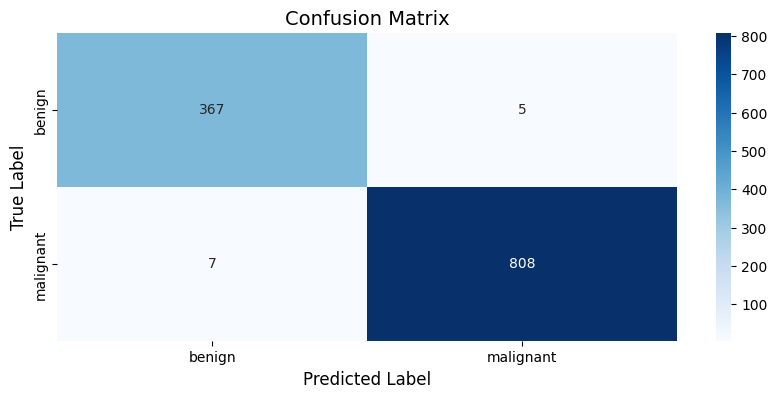

In [299]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [300]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 98.99%
Accuracy for each class:
Class 0: 98.66%
Class 1: 99.14%


### SAvg

Accuracy: 0.9755555555555555

In [301]:
# Calculate the average of the softmax outputs for each image
SAvg_predictions_rn101 = (predictions_rn101_cc + predictions_rn101_ca + predictions_rn101_sa + predictions_rn101_sea) / 4

# Take the argmax of the averaged softmax outputs to get the predicted classes
SMavg_predictions = np.argmax(SAvg_predictions_rn101, axis=1)

In [302]:
y_pred = SMavg_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9898904802021904


In [303]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9899116537759721
Weighted Recall (sensitivity): 0.9898904802021904
Weighted F1-Score: 0.9898978220585626
Weighted Specificity: 0.9880797025275411


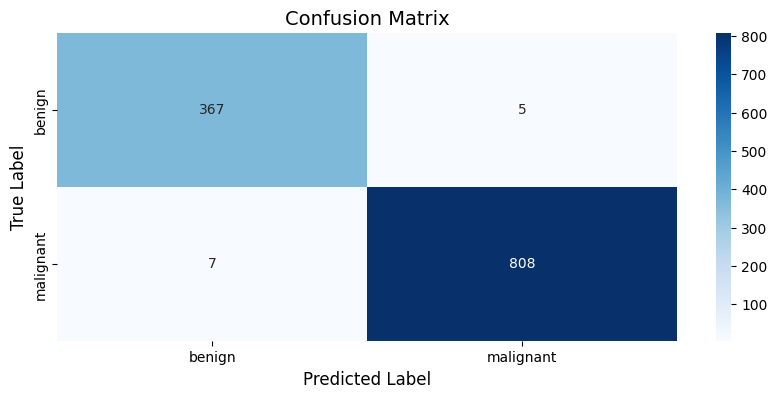

In [304]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [305]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 98.99%
Accuracy for each class:
Class 0: 98.66%
Class 1: 99.14%


# WAvg

In [306]:
# weighted average 0.20, .40, .40

# Define the weights for each model's prediction
weights = [0.1, 0.5, 0.2, 0.2]

In [307]:
# Calculate the weighted average of the softmax outputs for each image
WAvg_predictions_rn101  = (weights[0] * predictions_rn101_ca) + (weights[1] * predictions_rn101_sea) + (weights[2] * predictions_rn101_sa) + (weights[3] * predictions_rn101_cc)/ 4

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(WAvg_predictions_rn101, axis=1)

In [308]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.9924178601516428


In [309]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9924489606201833
Weighted Recall (sensitivity): 0.9924178601516428
Weighted F1-Score: 0.9924260950371795
Weighted Specificity: 0.992155660529141


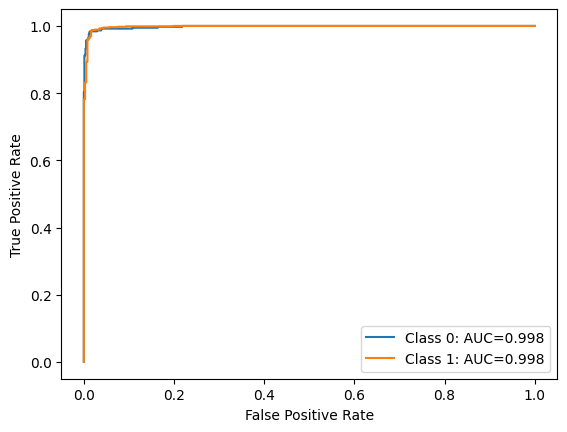

RN101_1st


In [310]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("RN101_1st")

**RN152**

**Data Generation**

In [311]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [312]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 15984 images belonging to 2 classes.

Test Batches: 
Found 1187 images belonging to 2 classes.

Val Batches: 
Found 1186 images belonging to 2 classes.


### Import model

In [313]:
from tensorflow.keras.applications.resnet import ResNet152

RN152 = ResNet152(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

234698864/234698864 [==============================] - 9s 0us/step


In [314]:
MainInput=Input(shape=(image_size, image_size, 3))
rn152 = RN152(MainInput)
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((16, 16, 8))(rn152)

# RN152-ccnn

In [315]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn152 = Model(inputs=MainInput, outputs=conv)

2


In [316]:
from tensorflow.keras import models
model_rn152.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN152.hdf5")

In [317]:
predictions_rn152_cc = model_rn152.predict(test_batches)

75/75 [==============================] - 18s 213ms/step


In [318]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn152_cc, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn152_cc

In [319]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.97      0.96       372
   malignant       0.98      0.98      0.98       815

    accuracy                           0.98      1187
   macro avg       0.97      0.97      0.97      1187
weighted avg       0.98      0.98      0.98      1187



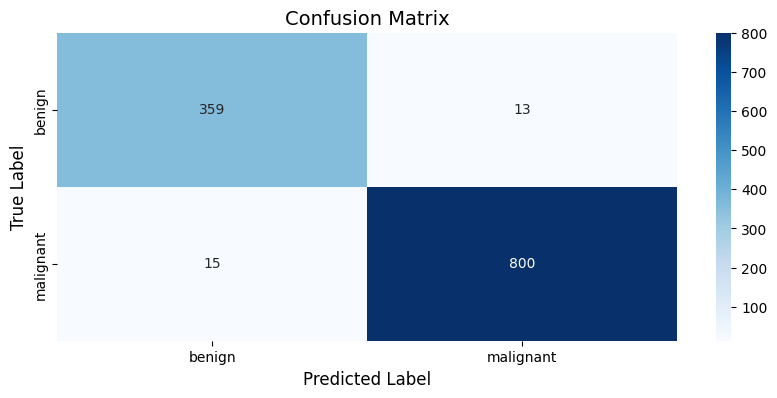

In [320]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [321]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9764111204717776


In [322]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn152_cc, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn152_cc, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9764111204717776
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [323]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9764517553360911
Weighted Recall (sensitivity): 0.9764111204717776
Weighted F1-Score: 0.9764282514699791
Weighted Specificity: 0.9702377349936224


**RN152-cacnn**

Accuracy: 0.9666666666666667

In [324]:
# Channel Attention
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class ChannelAttention(Layer):
    def __init__(self, reduction=16):
        super(ChannelAttention, self).__init__()
        self.reduction = reduction

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()

        self.shared_layer_one = Dense(units=self.channels // self.reduction, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = Dense(units=self.channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    def call(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_pool = Reshape((1, 1, self.channels))(avg_pool)
        max_pool = Reshape((1, 1, self.channels))(max_pool)
        shared_layer_one = self.shared_layer_one(avg_pool) + self.shared_layer_one(max_pool)
        shared_layer_two = self.shared_layer_two(shared_layer_one)
        return x * shared_layer_two

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'reduction': self.reduction,
        })
        return config

In [325]:
conv=(Conv2D(filters=128,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=128,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv=(Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
conv=(BatchNormalization()(conv))
conv = ChannelAttention()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn152_ca = Model(inputs=MainInput, outputs=conv)

2


In [326]:
from tensorflow.keras import models
model_rn152_ca.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN152_CA.hdf5")


In [327]:
predictions_rn152_ca = model_rn152_ca.predict(test_batches)

75/75 [==============================] - 20s 217ms/step


In [328]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn152_ca, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn152_ca


In [329]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.99      0.98      0.98       372
   malignant       0.99      0.99      0.99       815

    accuracy                           0.99      1187
   macro avg       0.99      0.99      0.99      1187
weighted avg       0.99      0.99      0.99      1187



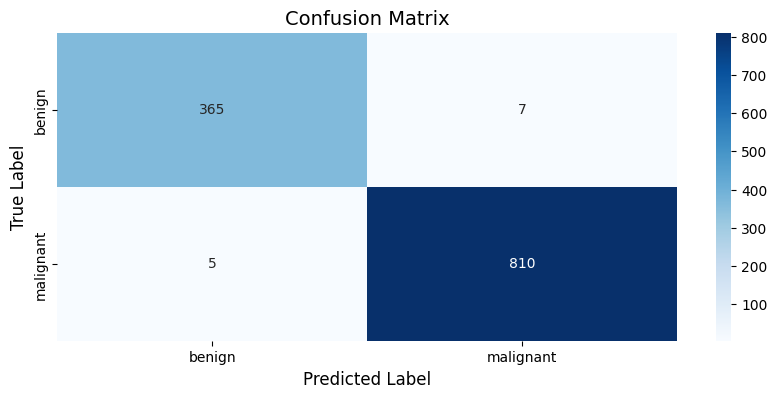

In [330]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [331]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9898904802021904


In [332]:
import numpy as np
from sklearn.metrics import accuracy_score


# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn152_ca, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn152_ca, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9898904802021904
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [333]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9898821472922377
Weighted Recall (sensitivity): 0.9898904802021904
Weighted F1-Score: 0.9898830500711355
Weighted Specificity: 0.985157346171581


**RN152-seacnn**

Accuracy: 0.9733333333333334

In [334]:
def squeeze_excite_block(input, filters, se_ratio):
    # Squeeze step
    se = tf.keras.layers.GlobalAveragePooling2D()(input)
    se = tf.keras.layers.Dense(filters // se_ratio, activation='relu')(se)
    se = tf.keras.layers.Dense(filters, activation='sigmoid')(se)
    # Excitation step
    x = tf.keras.layers.multiply([input, se])
    return x

In [335]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_2 = 16
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_2, image_size_2, 128,))(conv)
x = squeeze_excite_block(conv, 128, 128)  # use same number of filters as the input tensor
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(strides=(2, 2),padding="same")(conv))
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
image_size_3 = 8
from tensorflow.keras.layers import Reshape
conv = Reshape(target_shape=(image_size_3, image_size_3, 256,))(conv)
x = squeeze_excite_block(conv, 256, 256)  # use same number of filters as the input tensor
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(x)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))
num_classes = test_batches.num_classes
print(num_classes)
9
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv=(Dense(512,activation="relu")(conv))
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn152_sea = Model(inputs=MainInput, outputs=conv)

2


In [336]:
from tensorflow.keras import models
model_rn152_sea.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN152_SEA.hdf5")


In [337]:
predictions_rn152_sea = model_rn152_sea.predict(test_batches)

75/75 [==============================] - 19s 216ms/step


In [338]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn152_sea, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn152_sea


In [339]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97       372
   malignant       0.99      0.98      0.99       815

    accuracy                           0.98      1187
   macro avg       0.98      0.98      0.98      1187
weighted avg       0.98      0.98      0.98      1187



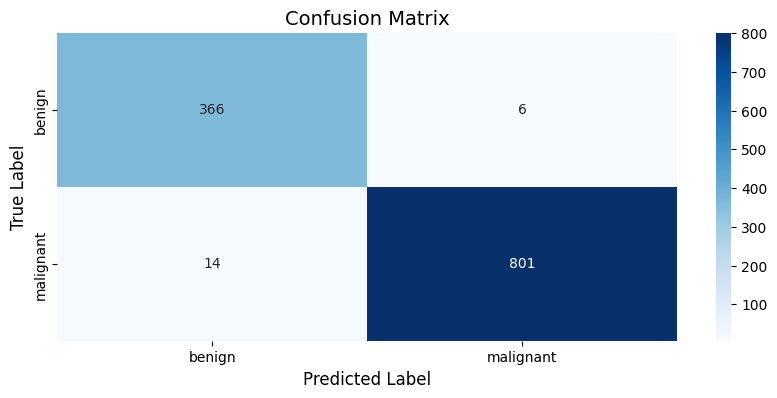

In [340]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [341]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.983150800336984


In [342]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn152_sea, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn152_sea, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.983150800336984
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [343]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9833489951880386
Weighted Recall (sensitivity): 0.983150800336984
Weighted F1-Score: 0.9831988720756661
Weighted Specificity: 0.983542253294522


**RN152-sacnn**

Accuracy: 0.9666666666666667

In [344]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf



class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

In [345]:
# Add convolutional layers with Channel Attention
conv = Conv2D(filters=128, kernel_size=(7, 7), activation="relu", padding="same", kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(5, 5), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=128, kernel_size=(1, 1), activation="relu", padding="same", kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention_2')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)
num_classes = test_batches.num_classes
print(num_classes)
conv=(Flatten()(conv))
conv=(Dense(1024,activation="relu")(conv))
conv = Dropout(0.5)(conv)
conv=(Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv=(Dense(num_classes, activation="sigmoid")(conv))

model_rn152_sa = Model(inputs=MainInput, outputs=conv)

2


In [346]:
from tensorflow.keras import models
model_rn152_sa.load_weights("/kaggle/input/dn-rn-ensemble/DN RN HDF/RN152_SA.hdf5")


In [347]:
predictions_rn152_sa = model_rn152_sa.predict(test_batches)

75/75 [==============================] - 18s 211ms/step


In [348]:
#geting predictions on test dataset
y_pred = np.argmax(predictions_rn152_sa, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions_rn152_sa

In [349]:
classnames = ['benign', 'malignant']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97       372
   malignant       0.99      0.98      0.99       815

    accuracy                           0.98      1187
   macro avg       0.98      0.98      0.98      1187
weighted avg       0.98      0.98      0.98      1187



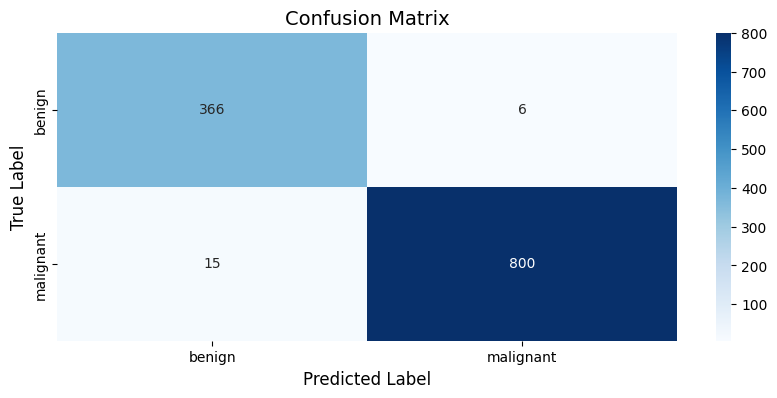

In [350]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [351]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))


Accuracy: 0.9823083403538332


In [352]:
import numpy as np
from sklearn.metrics import accuracy_score

# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions_rn152_sa, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions_rn152_sa, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9823083403538332
Top-2 Accuracy: 1.0
Top-3 Accuracy: 1.0


In [353]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9825504070682822
Weighted Recall (sensitivity): 0.9823083403538332
Weighted F1-Score: 0.9823649542212733
Weighted Specificity: 0.9831577194126422


# MV

In [354]:
# Take the majority vote of the predictions for each image
MV_predictions_rn152 = predictions_rn152_cc + predictions_rn152_ca + predictions_rn152_sa + predictions_rn152_sea

# Take the argmax of the outputs to get the predicted classes
MV_predictions_rn152_f = np.argmax(MV_predictions_rn152, axis=1)

In [355]:
y_pred = MV_predictions_rn152_f
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.987363100252738


In [356]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9874488304946623
Weighted Recall (sensitivity): 0.987363100252738
Weighted F1-Score: 0.9873858381066531
Weighted Specificity: 0.9869261008819014


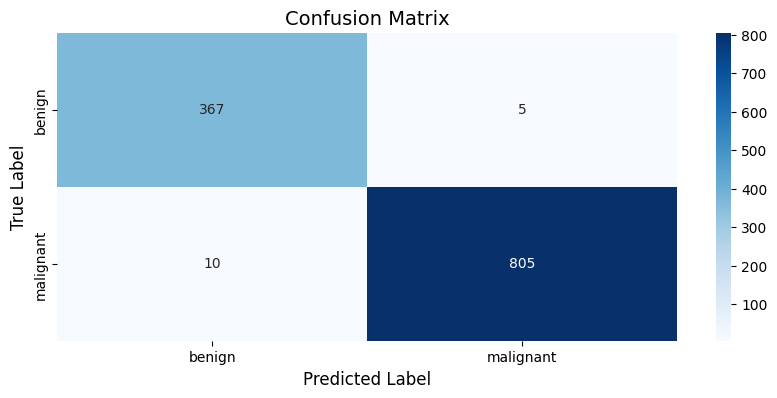

In [357]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [358]:
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 98.74%
Accuracy for each class:
Class 0: 98.66%
Class 1: 98.77%


# SAvg

In [359]:
# Calculate the average of the softmax outputs for each image
SAvg_predictions_rn152 = (predictions_rn152_cc + predictions_rn152_ca + predictions_rn152_sa + predictions_rn152_sea) / 4

# Take the argmax of the averaged softmax outputs to get the predicted classes
SMavg_predictions = np.argmax(SAvg_predictions_rn152, axis=1)

In [360]:
y_pred = SMavg_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.987363100252738


In [361]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9874488304946623
Weighted Recall (sensitivity): 0.987363100252738
Weighted F1-Score: 0.9873858381066531
Weighted Specificity: 0.9869261008819014


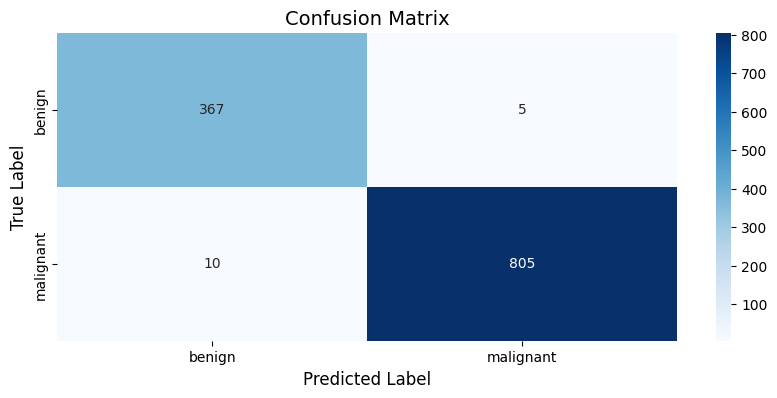

In [362]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [363]:
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 98.74%
Accuracy for each class:
Class 0: 98.66%
Class 1: 98.77%


### WAvg

Accuracy: 0.9755555555555555

In [364]:
# Define the weights for each model's prediction
weights = [0.50, 0.10, 0.05, 0.35]

In [365]:
# Calculate the weighted average of the softmax outputs for each image
WAvg_predictions_rn152 = (weights[0] * predictions_rn152_ca) + (weights[1] * predictions_rn152_sea) + (weights[2] * predictions_rn152_sa) + (weights[3] * predictions_rn152_cc) / 4

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(WAvg_predictions_rn152, axis=1)

In [366]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.991575400168492


In [367]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.991575400168492
Weighted Recall (sensitivity): 0.991575400168492
Weighted F1-Score: 0.991575400168492
Weighted Specificity: 0.9888487702913009


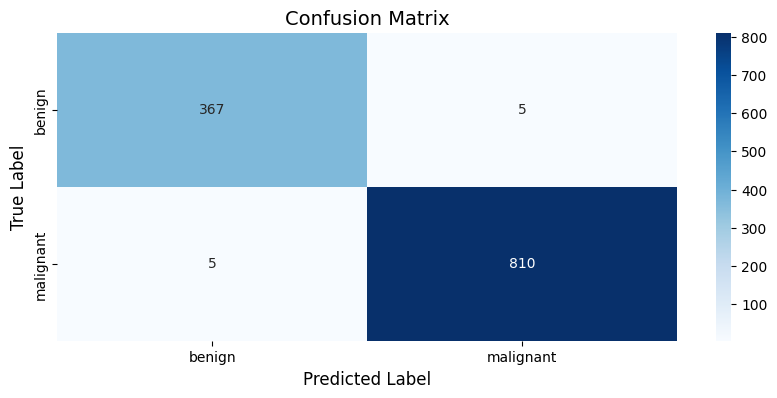

In [368]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [369]:
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.16%
Accuracy for each class:
Class 0: 98.66%
Class 1: 99.39%


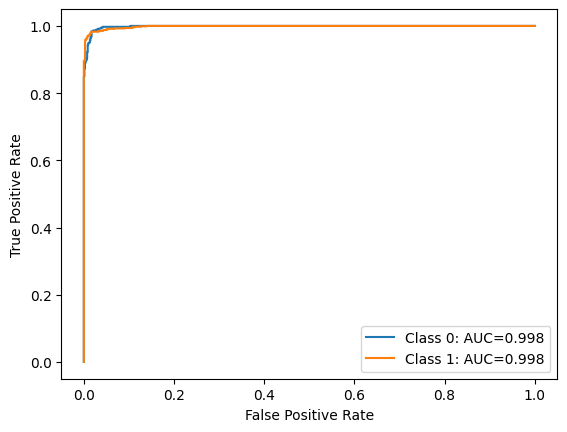

RN152_1st


In [370]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("RN152_1st")

### 2nd layer RN

Accuracy: 0.9777777777777777

In [371]:
# dn121 = most
# dn201 = 2nd most
# dn169 = 3rd

In [372]:
# Define the weights for each model's prediction
weights = [ 0.30, 0.50,0.20]

In [373]:
# Calculate the weighted average of the softmax outputs for each image
weighted_predictions_rn2 = (weights[0] * MV_predictions_rn50) + (weights[1] * WAvg_predictions_rn152) + (weights[2] * SAvg_predictions_rn101) / 3

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(weighted_predictions_rn2, axis=1)

In [374]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.991575400168492


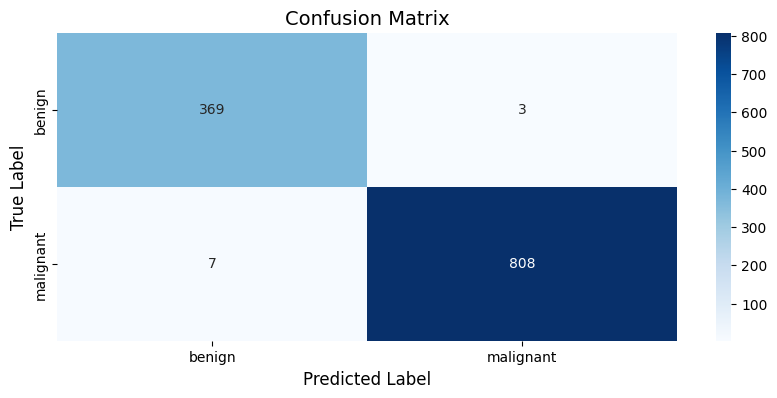

In [375]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

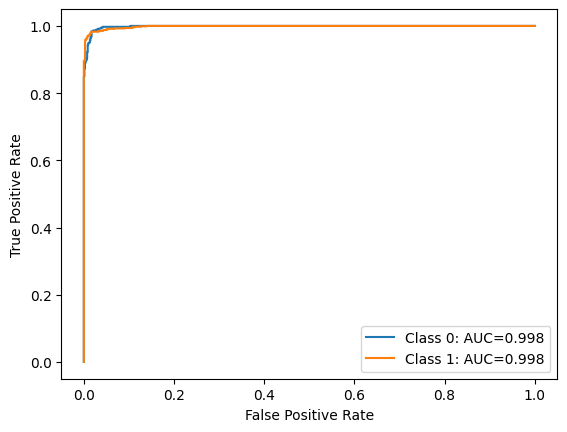

RN_Combined


In [376]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("RN_Combined")

In [377]:
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.16%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.14%


Data Generation

**3rd Layer**

In [378]:
# Define the weights for each model's prediction
weights = [0.60, 0.40]

In [379]:
# Calculate the weighted average of the softmax outputs for each image
weighted_predictions_f = (weights[0] * weighted_predictions_dn2) + (weights[1] * weighted_predictions_rn2)  / 3

# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(weighted_predictions_f, axis=1)




In [380]:
y_pred = weighted_predictions
y_true = test_batches.classes

# Evaluate the accuracy of the majority vote predictions on the test data
accuracy = np.mean(y_pred == y_true)
print("Accuracy:", accuracy)

Accuracy: 0.995787700084246


In [381]:
import numpy as np
from sklearn.metrics import accuracy_score


from sklearn.metrics import f1_score

In [382]:
### Weighted Evaluation Measures
print("Weighted Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Weighted Recall (sensitivity): "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Weighted F1-Score: "+ str(f1_score(y_true, y_pred, average='weighted')))
print("Weighted Specificity: "+ str(specificity_score(y_true, y_pred, average='weighted')))
# print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Weighted Precision: 0.9957862558003444
Weighted Recall (sensitivity): 0.995787700084246
Weighted F1-Score: 0.9957861567518209
Weighted Specificity: 0.9936937960566604


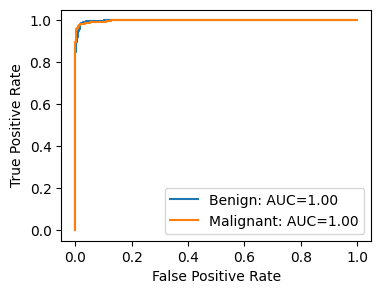

In [383]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = {}
tpr = {}
roc_auc = dict()

# Define class names (replace with your actual class names)
class_names = ["Benign", "Malignant"]

# Specify the size of the image
plt.figure(figsize=(4, 3))  # Adjust the width and height as needed

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='{}: AUC={:.2f}'.format(class_names[i], roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Save the image as a PDF without wasted space
plt.savefig('ROC.pdf', bbox_inches='tight', format='pdf')
plt.show()

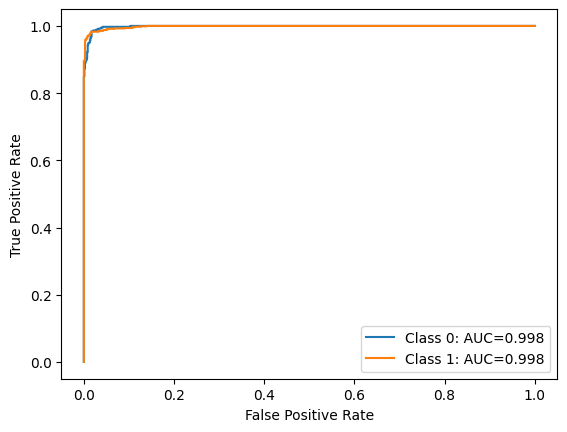

DN_RN_Combined


In [384]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("DN_RN_Combined")

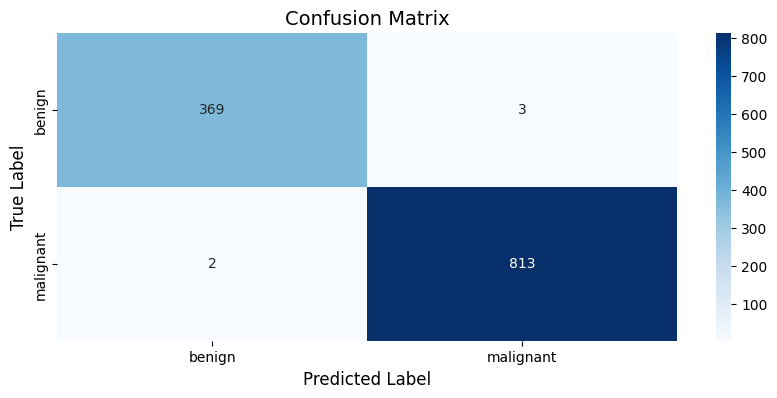

In [385]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

In [386]:
### Individual Class Accuracy
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 99.58%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.75%


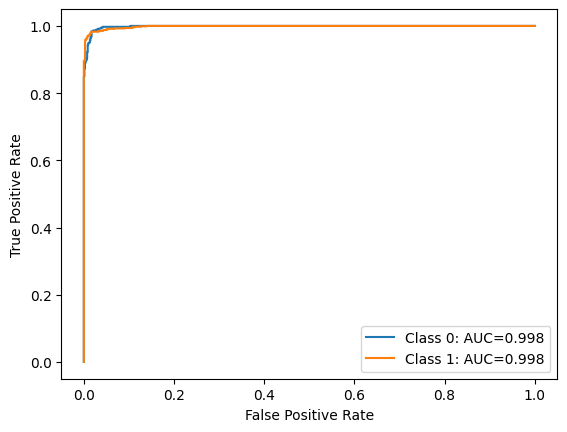

In [387]:
from sklearn.metrics import roc_curve, auc
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(2):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Accuracy: 0.9949452401010952
Weighted Precision: 0.9949452401010952
Weighted Recall (sensitivity): 0.9949452401010952
Weighted F1-Score: 0.9949452401010952


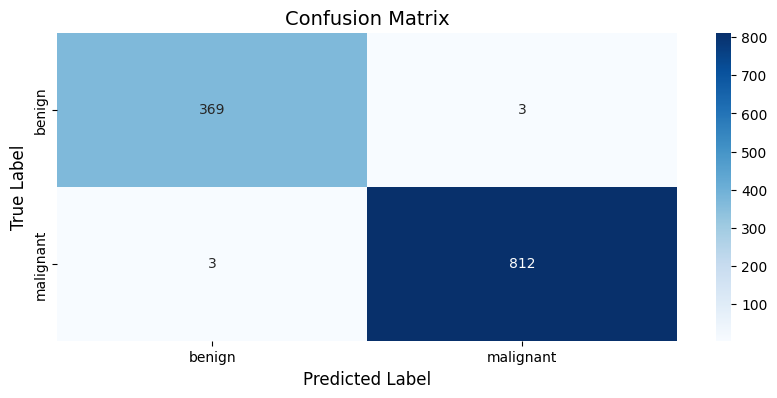

Overall accuracy: 99.49%
Accuracy for each class:
Class 0: 99.19%
Class 1: 99.63%


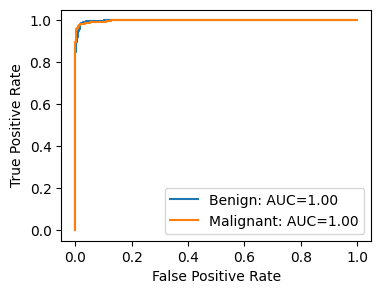


Time Taken Per Step:
Weighted Predictions: 0.0002 seconds
Accuracy Calculation: 0.0002 seconds
Weighted Evaluation Measures: 0.0047 seconds
Confusion Matrix: 0.0006 seconds
Class Accuracy Calculation: 0.0001 seconds
ROC and AUC Calculation: 0.0024 seconds


In [388]:
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize timing dictionary
time_taken = {}

# Start timing the weighted predictions calculation
start_time = time.time()
# Calculate the weighted average of the softmax outputs for each image
weighted_predictions_f = (weights[0] * weighted_predictions_dn2 + weights[1] * weighted_predictions_rn2) / 3
# Take the argmax of the weighted softmax outputs to get the predicted classes
weighted_predictions = np.argmax(weighted_predictions_f, axis=1)
time_taken['Weighted Predictions'] = time.time() - start_time

# Evaluate accuracy
start_time = time.time()
y_pred = weighted_predictions
y_true = test_batches.classes
accuracy = np.mean(y_pred == y_true)
time_taken['Accuracy Calculation'] = time.time() - start_time
print("Accuracy:", accuracy)

# Weighted evaluation measures
start_time = time.time()
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
time_taken['Weighted Evaluation Measures'] = time.time() - start_time
print("Weighted Precision:", precision)
print("Weighted Recall (sensitivity):", recall)
print("Weighted F1-Score:", f1)

# Confusion matrix
start_time = time.time()
cm = confusion_matrix(y_true, y_pred)
time_taken['Confusion Matrix'] = time.time() - start_time

# Plotting confusion matrix
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict={'size': 12})
plt.ylabel('True Label', fontdict={'size': 12})
plt.title('Confusion Matrix', fontdict={'size': 14})
plt.show()

# Calculate accuracy for each class
start_time = time.time()
class_accuracy = cm.diagonal() / cm.sum(axis=1)
time_taken['Class Accuracy Calculation'] = time.time() - start_time
print("Overall accuracy: {:.2f}%".format(accuracy * 100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print(f"Class {i}: {acc*100:.2f}%")

# ROC curve and AUC for each class
start_time = time.time()
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
time_taken['ROC and AUC Calculation'] = time.time() - start_time

# Plot ROC curve for each class
plt.figure(figsize=(4, 3))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]}: AUC={roc_auc[i]:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('ROC.pdf', bbox_inches='tight', format='pdf')
plt.show()

# Print timing results
print("\nTime Taken Per Step:")
for step, t in time_taken.items():
    print(f"{step}: {t:.4f} seconds")


In [389]:
from tqdm import tqdm
import time

# Simulate a progress bar for the operation
steps = 75  # Replace with the actual number of steps or a representative value
batch_time = 0.25  # Approximate time per step, adjust as needed

start_time = time.time()
for step in tqdm(range(steps), desc="Calculating Weighted Predictions", unit="step"):
    time.sleep(batch_time / steps)  # Simulate time for each step

# Perform the actual calculation
weighted_predictions_f = (weights[0] * weighted_predictions_dn2 + weights[1] * weighted_predictions_rn2) / 3
time_taken['Weighted Predictions Calculation'] = time.time() - start_time

print(f"Weighted predictions completed in {time_taken['Weighted Predictions Calculation']:.2f} seconds")


Calculating Weighted Predictions: 100%|██████████| 75/75 [00:00<00:00, 290.49step/s]

Weighted predictions completed in 0.26 seconds
